In [1]:
#List of imports

import networkx as nx
import numpy as np
import pickle
from pathlib import Path
import os
import torch
import time
import dgl
import WLColorRefinement as wl
import CSL_data
import Molecules_data


Using backend: pytorch


In [2]:
"""
    Download MOLECULES datasets
"""
# if not os.path.isfile('molecules.zip'):
#     print('downloading..')
#     !curl https://www.dropbox.com/s/feo9qle74kg48gy/molecules.zip?dl=1 -o molecules.zip -J -L -k
# else:
#     print('File already downloaded')

'\n    Download MOLECULES datasets\n'

In [3]:
"""
    Get CSL graphs and send to color function
"""
# CSL_graphs = CSL_data.get_CSL_graphs()



"""
    Get ZINC graphs
"""
ZINC_graphs = Molecules_data.MoleculeDatasetDGL('ZINC')

preparing 10000 graphs for the TRAIN set...


C:\Users\User1\Documents\GitHub\ResearchProject1\WLColorRefinement\Molecules_data.py:59: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  edge_list = (adj != 0).nonzero()  # converting adj matrix to edge_list
C:\Users\User1\anaconda3\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


preparing 1000 graphs for the VAL set...
preparing 1000 graphs for the TEST set...
Time taken: 741.7666s


Original Graph 



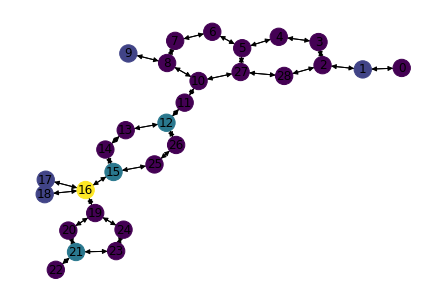

In [4]:
"""
    Send the CSL graphs to the coloring function
"""
# CSL_graphs_colored = list()

# for i in CSL_graphs:
#     CSL_graphs_colored.append(wl.wl_coloring(i))

"""
    Send the ZINC graphs to the coloring function
"""
ZINC_graphs_colored = list()

print('Original Graph', '\n')
x = ZINC_graphs.train.__getitem__(0)[0]
nx_x = x.to_networkx()
pos = nx.kamada_kawai_layout(nx_x)
nx.draw(nx_x, pos, with_labels=True, node_color=x.ndata['feat'])

for graph in ZINC_graphs.train:
    ZINC_graphs_colored.append(wl.wl_coloring(graph.__getitem__(0)))

Colored Graph 



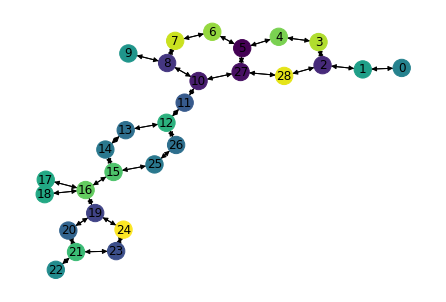

In [5]:
y = ZINC_graphs_colored[0]
print('Colored Graph \n')
# print(y)
# print('nodes data: ', y.nodes())
# print('nodes features: ', y.ndata)
# print('edges data: ', y.edges())
# print('edges features: ', y.edata)
nx_y = y.to_networkx()
pos = nx.kamada_kawai_layout(nx_y)
nx.draw(nx_y, pos, with_labels=True, node_color=y.ndata['feat'])

In [144]:
"""
    super_node(dgl.DGLgraph)
    
    Function to create a supernode
    The idea is to have a function that iterates over the graph and
    finds the nodes with the same colors and then places them in one supernode
"""

def super_node(graph):
    super_node = {}
    colors = graph.ndata['feat'].numpy()
    nodes = graph.nodes().numpy()

    count = len(colors)
    i = 0
    while i < count:
        if colors[i] not in super_node:
            super_node[colors[i]] = dict()
        super_node[colors[i]][nodes[i]] = list()
        i += 1
    edges = create_edge_list(graph)
    super_node, weights = super_edge(edges, super_node)
#     print('weights: ', weights)
    mapping = create_mapping(super_node)
    return create_DGLgraph(super_node, weights, mapping)

In [52]:
"""
    Create_edge_list(dgl.DGLgraph)
    
    Function to create a list with (source node, destination node)
"""

def create_edge_list(graph):
    src_edges = graph.edges(form='uv', order='srcdst')[0].numpy()
    dst_edges = graph.edges(form='uv', order='srcdst')[1].numpy()
    
    concat_edges = list()
    for i in range(0, len(src_edges)):
        sub_list = list()
        sub_list.append(src_edges[i])
        sub_list.append(dst_edges[i])
        concat_edges.append(sub_list)
    return concat_edges  

In [53]:
"""
    super_edge(list, dict)
    
    Function to find the edges between supernodes and calculate the weight of the edges.
    The weight of the edge is the total of edges that go from one node within the supernode to another node in another supernode.
    If the number of edges from each node going out are not the same, the smallest common value is taken.
    
    Make sure that the the src_edges of the create_edge_list function is sorted from low to high.
"""

def super_edge(edges, super_node):
    weights = {}
    for color in super_node:
        weights[color]=-1
        for node in super_node[color]:
            for edge in edges:
                if node == edge[0]:
                    super_node[color][node].append(edge)
                elif node < edge[0]:
                    weight = len(super_node[color][node])
                    if weights[color] != -1 & (weights[color] > weight):
                        weights[color] = weight
                    else:
                        weights[color] = weight
                    break
    return (super_node, weights)

In [54]:
"""
    create_mapping(dict)
    @super_node - the supernode with original nodes added to it and a list of original edges
    
    Create a mapping from one nodes to super nodes.
"""

def create_mapping(super_node):
    mapping = {}
    for color in super_node:
        for node in super_node[color]:
            mapping[node] = color
#     print(mapping)
    return mapping

In [146]:
"""
    create_DGLgraph(dict, dict)
    
    Create a DGLgraph with the following steps:
        1. Overwrite the original node with the color of the supernode
        2. Add the weights to the edges
"""

def create_DGLgraph(super_node, weights, mapping):
    for color, nodes in super_node.items():
        for node, edges in nodes.items():
            i = 0
            while i < len(edges):
                super_node[color][node][i][0] = mapping[edges[i][0]]
                super_node[color][node][i][1] = mapping[edges[i][1]]
                i += 1
    
    return super_node
        
        

In [147]:
superNode = super_node(ZINC_graphs_colored[0])

weights:  {230: 1, 233: 2, 222: 3, 241: 2, 239: 2, 219: 3, 240: 2, 242: 2, 223: 3, 232: 1, 221: 3, 226: 2, 235: 3, 228: 2, 229: 2, 237: 3, 238: 4, 234: 1, 224: 3, 227: 2, 236: 3, 231: 1, 225: 2, 244: 2, 220: 3, 243: -1}
{0: 230, 1: 233, 2: 222, 3: 241, 4: 239, 5: 219, 6: 240, 7: 242, 8: 223, 9: 232, 10: 221, 11: 226, 12: 235, 13: 228, 26: 228, 14: 229, 25: 229, 15: 237, 16: 238, 17: 234, 18: 234, 19: 224, 20: 227, 21: 236, 22: 231, 23: 225, 24: 244, 27: 220, 28: 243}
